# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [3]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [4]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

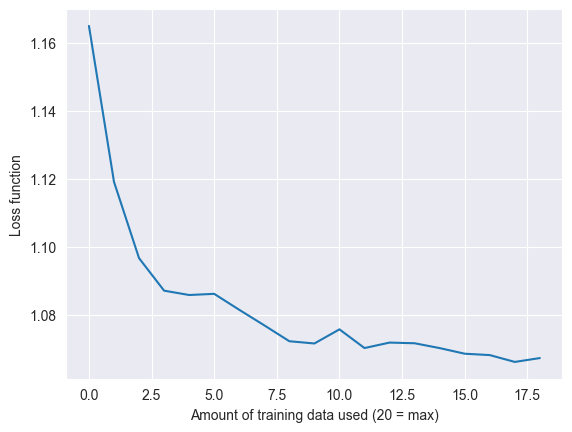

In [5]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [6]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

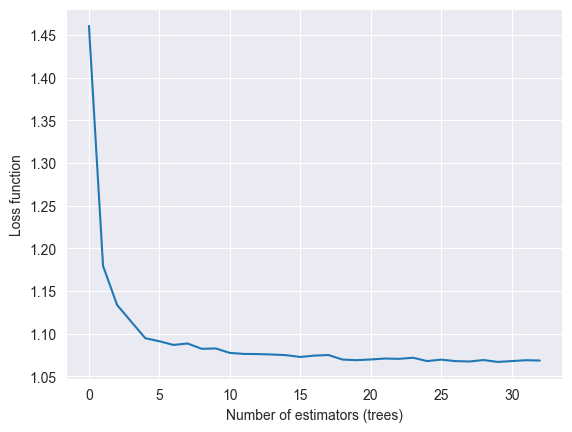

In [7]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

I would keep the first graph which shows the amount of training data used vs the second graph which shows the number of estimators. The reason is, the training data size graph shows how much data we actually need. It shows more of a learning curve compared to the second graph. It shows a clear improvement which is followed by diminishing returns. Around 60% or 12.5 it shows the point of max data needed. The second graph shows more predictable behavior which is that Random Forest quickly plateaus with more trees.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

## Analysis of Kidney Disease Datasets

### 3.1 Loading and Preparing the Datasets

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

ckd_df = pd.read_csv('../../datasets/chronic_kidney_disease.csv')
dn_df = pd.read_csv('../../datasets/diabetic_nephropathy.csv')
aki_df = pd.read_csv('../../datasets/acute_kidney_injury.csv')

print("Datasets loaded successfully!")
print(f"CKD dataset shape: {ckd_df.shape}")
print(f"Diabetic Nephropathy dataset shape: {dn_df.shape}")
print(f"Acute Kidney Injury dataset shape: {aki_df.shape}")

Datasets loaded successfully!
CKD dataset shape: (202, 29)
Diabetic Nephropathy dataset shape: (767, 22)
Acute Kidney Injury dataset shape: (4001, 57)


### 3.2.1 Data Preprocessing for CKD Dataset

In [9]:
ckd_df_clean = ckd_df.iloc[2:].copy()

def extract_numeric_from_range(val):
    if pd.isna(val):
        return np.nan
    val_str = str(val)
    if '<' in val_str:
        return float(val_str.replace('<', '').strip()) * 0.9
    elif '≥' in val_str:
        return float(val_str.replace('≥', '').strip()) * 1.1
    elif '-' in val_str:
        parts = val_str.split('-')
        if len(parts) == 2:
            try:
                return (float(parts[0].strip()) + float(parts[1].strip())) / 2
            except:
                return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

numeric_columns = ['age', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'grf']
for col in numeric_columns:
    if col in ckd_df_clean.columns:
        ckd_df_clean[f'{col}_numeric'] = ckd_df_clean[col].apply(extract_numeric_from_range)

ckd_features = ['age_numeric', 'bgr_numeric', 'bu_numeric', 'sc_numeric', 
                'sod_numeric', 'pot_numeric', 'hemo_numeric']
ckd_target_regression = 'grf_numeric'
ckd_target_classification = 'class'

print("CKD preprocessing complete!")

CKD preprocessing complete!


### 3.2.2 Data Preprocessing for Diabetic Nephropathy Dataset

In [10]:
dn_df.columns = dn_df.columns.str.strip()

print(f"DN dataset shape before cleaning: {dn_df.shape}")
print(f"Missing values per column:\n{dn_df.isnull().sum()}")

dn_features = ['Age', 'Diabetes duration (y)', 'BMI (kg/m2)', 'SBP (mmHg)', 
               'DBP (mmHg)', 'HbA1c (%)', 'FBG (mmol/L)']
dn_target = 'Diabetic nephropathy (DN)'

for col in dn_features:
    if col in dn_df.columns:
        dn_df[col] = pd.to_numeric(dn_df[col], errors='coerce')

dn_df[dn_target] = pd.to_numeric(dn_df[dn_target], errors='coerce')

print(f"\nDN dataset shape after cleaning: {dn_df.shape}")
print("Diabetic Nephropathy preprocessing complete!")

DN dataset shape before cleaning: (767, 22)
Missing values per column:
Sex                          0
Age                          0
Diabetes duration (y)        1
Diabetic retinopathy (DR)    0
Diabetic nephropathy (DN)    0
Smoking                      0
Drinking                     0
Height(cm)                   1
Weight(kg)                   0
BMI (kg/m2)                  1
SBP (mmHg)                   0
DBP (mmHg)                   0
HbA1c (%)                    3
FBG (mmol/L)                 1
TG（mmoll）                    5
C-peptide (ng/ml）            1
TC（mmoll）                    5
HDLC（mmoll）                  7
LDLC（mmoll）                  7
Insulin                      0
Metformin                    0
Lipid lowering drugs         0
dtype: int64

DN dataset shape after cleaning: (767, 22)
Diabetic Nephropathy preprocessing complete!


### 3.2.3 Data Preprocessing for AKI Dataset

In [11]:
print(f"AKI dataset shape before cleaning: {aki_df.shape}")
print(f"Missing values per column:\n{aki_df.isnull().sum().head(10)}")

aki_features = ['age', 'sapsii', 'scr', 'bun', 'nlr', 'plr', 'hb', 'lactate']
aki_target_regression = 'sofa'
aki_target_classification = 'mort_28_day'

for col in aki_features:
    if col in aki_df.columns:
        aki_df[col] = pd.to_numeric(aki_df[col], errors='coerce')

aki_df[aki_target_regression] = pd.to_numeric(aki_df[aki_target_regression], errors='coerce')
aki_df[aki_target_classification] = pd.to_numeric(aki_df[aki_target_classification], errors='coerce')

aki_numeric_cols = aki_features + [aki_target_regression, aki_target_classification]
aki_df_clean = aki_df[aki_numeric_cols].copy()

print(f"\nAKI dataset shape after selecting features: {aki_df_clean.shape}")
print(f"Missing values in selected features:\n{aki_df_clean.isnull().sum()}")
print("\nAKI preprocessing complete!")

AKI dataset shape before cleaning: (4001, 57)
Missing values per column:
gender      0
age         0
race        0
unit        0
bmi       911
weight    192
t          98
p           3
r           7
bp          3
dtype: int64

AKI dataset shape after selecting features: (4001, 10)
Missing values in selected features:
age               0
sapsii            0
scr               0
bun               0
nlr               0
plr               0
hb                3
lactate        1310
sofa              0
mort_28_day       0
dtype: int64

AKI preprocessing complete!


### 3.3 Random Forest Models - Regression Tasks

In [12]:
ckd_regression_data = ckd_df_clean[ckd_features + [ckd_target_regression]].dropna()
X_ckd_reg = ckd_regression_data[ckd_features]
y_ckd_reg = ckd_regression_data[ckd_target_regression]

X_train_ckd_reg, X_test_ckd_reg, y_train_ckd_reg, y_test_ckd_reg = train_test_split(
    X_ckd_reg, y_ckd_reg, test_size=0.3, random_state=42
)

rf_ckd_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_ckd_reg.fit(X_train_ckd_reg, y_train_ckd_reg)

y_pred_ckd_reg = rf_ckd_reg.predict(X_test_ckd_reg)

mse_ckd = mean_squared_error(y_test_ckd_reg, y_pred_ckd_reg)
rmse_ckd = np.sqrt(mse_ckd)
r2_ckd = r2_score(y_test_ckd_reg, y_pred_ckd_reg)
explained_var_ckd = explained_variance_score(y_test_ckd_reg, y_pred_ckd_reg)

print("CKD Random Forest Regression Results (Predicting GFR):")
print(f"RMSE: {rmse_ckd:.2f}")
print(f"R² Score: {r2_ckd:.4f}")
print(f"Explained Variance: {explained_var_ckd:.4f}")
print(f"Correlation: {np.corrcoef(y_test_ckd_reg, y_pred_ckd_reg)[0,1]:.4f}")

CKD Random Forest Regression Results (Predicting GFR):
RMSE: 43.08
R² Score: 0.4119
Explained Variance: 0.4133
Correlation: 0.6614


In [14]:
dn_regression_data = dn_df[dn_features + [dn_target]].dropna()
X_dn_reg = dn_regression_data[dn_features]
y_dn_reg = dn_regression_data[dn_target]

X_train_dn_reg, X_test_dn_reg, y_train_dn_reg, y_test_dn_reg = train_test_split(
    X_dn_reg, y_dn_reg, test_size=0.3, random_state=42
)

rf_dn_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_dn_reg.fit(X_train_dn_reg, y_train_dn_reg)

y_pred_dn_reg = rf_dn_reg.predict(X_test_dn_reg)

mse_dn = mean_squared_error(y_test_dn_reg, y_pred_dn_reg)
rmse_dn = np.sqrt(mse_dn)
r2_dn = r2_score(y_test_dn_reg, y_pred_dn_reg)
explained_var_dn = explained_variance_score(y_test_dn_reg, y_pred_dn_reg)

print("\nDiabetic Nephropathy Random Forest Regression Results (Predicting DN):")
print(f"RMSE: {rmse_dn:.2f}")
print(f"R² Score: {r2_dn:.4f}")
print(f"Explained Variance: {explained_var_dn:.4f}")
print(f"Correlation: {np.corrcoef(y_test_dn_reg, y_pred_dn_reg)[0,1]:.4f}")


Diabetic Nephropathy Random Forest Regression Results (Predicting DN):
RMSE: 0.44
R² Score: -0.0051
Explained Variance: -0.0050
Correlation: 0.1916


In [15]:
aki_regression_data = aki_df_clean[aki_features + [aki_target_regression]].dropna()
X_aki_reg = aki_regression_data[aki_features]
y_aki_reg = aki_regression_data[aki_target_regression]

X_train_aki_reg, X_test_aki_reg, y_train_aki_reg, y_test_aki_reg = train_test_split(
    X_aki_reg, y_aki_reg, test_size=0.3, random_state=42
)

rf_aki_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_aki_reg.fit(X_train_aki_reg, y_train_aki_reg)

y_pred_aki_reg = rf_aki_reg.predict(X_test_aki_reg)

mse_aki = mean_squared_error(y_test_aki_reg, y_pred_aki_reg)
rmse_aki = np.sqrt(mse_aki)
r2_aki = r2_score(y_test_aki_reg, y_pred_aki_reg)
explained_var_aki = explained_variance_score(y_test_aki_reg, y_pred_aki_reg)

print("\nAKI Random Forest Regression Results (Predicting SOFA):")
print(f"RMSE: {rmse_aki:.2f}")
print(f"R² Score: {r2_aki:.4f}")
print(f"Explained Variance: {explained_var_aki:.4f}")
print(f"Correlation: {np.corrcoef(y_test_aki_reg, y_pred_aki_reg)[0,1]:.4f}")


AKI Random Forest Regression Results (Predicting SOFA):
RMSE: 2.42
R² Score: 0.5588
Explained Variance: 0.5612
Correlation: 0.7492


### 3.4  Classification Performance Metrics

In [16]:
ckd_classification_data = ckd_df_clean[ckd_features + [ckd_target_classification]].dropna()
X_ckd_class = ckd_classification_data[ckd_features]
y_ckd_class = ckd_classification_data[ckd_target_classification]

y_ckd_class = (y_ckd_class == 'ckd').astype(int)

X_train_ckd_class, X_test_ckd_class, y_train_ckd_class, y_test_ckd_class = train_test_split(
    X_ckd_class, y_ckd_class, test_size=0.3, random_state=42
)

rf_ckd_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_ckd_class.fit(X_train_ckd_class, y_train_ckd_class)

y_pred_ckd_class = rf_ckd_class.predict(X_test_ckd_class)
y_pred_proba_ckd = rf_ckd_class.predict_proba(X_test_ckd_class)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_ckd_class = accuracy_score(y_test_ckd_class, y_pred_ckd_class)
precision_ckd_class = precision_score(y_test_ckd_class, y_pred_ckd_class)
recall_ckd_class = recall_score(y_test_ckd_class, y_pred_ckd_class)
f1_ckd_class = f1_score(y_test_ckd_class, y_pred_ckd_class)

print("CKD Random Forest Classification Results:")
print(f"Accuracy: {accuracy_ckd_class:.4f}")
print(f"Precision: {precision_ckd_class:.4f}")
print(f"Recall: {recall_ckd_class:.4f}")
print(f"F1-Score: {f1_ckd_class:.4f}")

CKD Random Forest Classification Results:
Accuracy: 0.9500
Precision: 0.9459
Recall: 0.9722
F1-Score: 0.9589


In [17]:
dn_data = dn_df[dn_features + [dn_target]].dropna()
X_dn = dn_data[dn_features]
y_dn = dn_data[dn_target]

X_train_dn, X_test_dn, y_train_dn, y_test_dn = train_test_split(
    X_dn, y_dn, test_size=0.3, random_state=42
)

rf_dn = RandomForestClassifier(n_estimators=100, random_state=42)
rf_dn.fit(X_train_dn, y_train_dn)

y_pred_dn = rf_dn.predict(X_test_dn)
y_pred_proba_dn = rf_dn.predict_proba(X_test_dn)[:, 1]

accuracy_dn = accuracy_score(y_test_dn, y_pred_dn)
precision_dn = precision_score(y_test_dn, y_pred_dn)
recall_dn = recall_score(y_test_dn, y_pred_dn)
f1_dn = f1_score(y_test_dn, y_pred_dn)

print("\nDiabetic Nephropathy Random Forest Classification Results:")
print(f"Accuracy: {accuracy_dn:.4f}")
print(f"Precision: {precision_dn:.4f}")
print(f"Recall: {recall_dn:.4f}")
print(f"F1-Score: {f1_dn:.4f}")


Diabetic Nephropathy Random Forest Classification Results:
Accuracy: 0.7424
Precision: 0.5000
Recall: 0.1525
F1-Score: 0.2338


In [18]:
aki_classification_data = aki_df_clean[aki_features + [aki_target_classification]].dropna()
X_aki_class = aki_classification_data[aki_features]
y_aki_class = aki_classification_data[aki_target_classification]

X_train_aki_class, X_test_aki_class, y_train_aki_class, y_test_aki_class = train_test_split(
    X_aki_class, y_aki_class, test_size=0.3, random_state=42
)

rf_aki_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_aki_class.fit(X_train_aki_class, y_train_aki_class)

y_pred_aki_class = rf_aki_class.predict(X_test_aki_class)
y_pred_proba_aki = rf_aki_class.predict_proba(X_test_aki_class)[:, 1]

accuracy_aki_class = accuracy_score(y_test_aki_class, y_pred_aki_class)
precision_aki_class = precision_score(y_test_aki_class, y_pred_aki_class)
recall_aki_class = recall_score(y_test_aki_class, y_pred_aki_class)
f1_aki_class = f1_score(y_test_aki_class, y_pred_aki_class)

print("\nAKI Random Forest Classification Results (28-day Mortality):")
print(f"Accuracy: {accuracy_aki_class:.4f}")
print(f"Precision: {precision_aki_class:.4f}")
print(f"Recall: {recall_aki_class:.4f}")
print(f"F1-Score: {f1_aki_class:.4f}")


AKI Random Forest Classification Results (28-day Mortality):
Accuracy: 0.7757
Precision: 0.5789
Recall: 0.1737
F1-Score: 0.2672


In [19]:
print("="*60)
print("Cross-Validation Results")
print("="*60)

print("\n1. CKD Regression (Predicting GFR):")
cv_scores_ckd_reg = cross_val_score(rf_ckd_reg, X_ckd_reg, y_ckd_reg, 
                                    cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_ckd = -cv_scores_ckd_reg
cv_explained_var_ckd = cross_val_score(rf_ckd_reg, X_ckd_reg, y_ckd_reg, 
                                       cv=5, scoring='explained_variance')

print(f"CV RMSE: {cv_rmse_ckd.mean():.2f} (+/- {cv_rmse_ckd.std() * 2:.2f})")
print(f"CV Explained Variance: {cv_explained_var_ckd.mean():.4f} (+/- {cv_explained_var_ckd.std() * 2:.4f})")

print("\n2. CKD Classification (Predicting CKD Status):")
cv_scores_ckd_class = cross_val_score(rf_ckd_class, X_ckd_class, y_ckd_class, 
                                      cv=5, scoring='f1')
print(f"CV F1-Score: {cv_scores_ckd_class.mean():.4f} (+/- {cv_scores_ckd_class.std() * 2:.4f})")

print("\n3. Diabetic Nephropathy Classification:")
cv_scores_dn = cross_val_score(rf_dn, X_dn, y_dn, cv=5, scoring='f1')
print(f"CV F1-Score: {cv_scores_dn.mean():.4f} (+/- {cv_scores_dn.std() * 2:.4f})")

print("\n4. AKI Regression (Predicting SOFA):")
cv_scores_aki_reg = cross_val_score(rf_aki_reg, X_aki_reg, y_aki_reg, 
                                    cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_aki = -cv_scores_aki_reg
cv_explained_var_aki = cross_val_score(rf_aki_reg, X_aki_reg, y_aki_reg, 
                                       cv=5, scoring='explained_variance')

print(f"CV RMSE: {cv_rmse_aki.mean():.2f} (+/- {cv_rmse_aki.std() * 2:.2f})")
print(f"CV Explained Variance: {cv_explained_var_aki.mean():.4f} (+/- {cv_explained_var_aki.std() * 2:.4f})")

print("\n5. AKI Classification (28-day Mortality):")
cv_scores_aki_class = cross_val_score(rf_aki_class, X_aki_class, y_aki_class, 
                                      cv=5, scoring='f1')
print(f"CV F1-Score: {cv_scores_aki_class.mean():.4f} (+/- {cv_scores_aki_class.std() * 2:.4f})")

Cross-Validation Results

1. CKD Regression (Predicting GFR):
CV RMSE: 38.26 (+/- 30.34)
CV Explained Variance: 0.3929 (+/- 0.4003)

2. CKD Classification (Predicting CKD Status):
CV F1-Score: 0.9313 (+/- 0.1432)

3. Diabetic Nephropathy Classification:
CV F1-Score: 0.2591 (+/- 0.2088)

4. AKI Regression (Predicting SOFA):
CV RMSE: 2.35 (+/- 0.11)
CV Explained Variance: 0.5737 (+/- 0.0614)

5. AKI Classification (28-day Mortality):
CV F1-Score: 0.2631 (+/- 0.0916)


### 3.5 Hyperparameter Tuning with GridSearchCV

In [20]:
print("="*60)
print("GridSearchCV Hyperparameter Tuning")
print("="*60)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\n1. CKD Dataset - GridSearchCV")
grid_search_ckd = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_ckd.fit(X_train_ckd_reg, y_train_ckd_reg)

print(f"Best parameters: {grid_search_ckd.best_params_}")
print(f"Best CV RMSE: {-grid_search_ckd.best_score_:.2f}")

best_rf_ckd = grid_search_ckd.best_estimator_
y_pred_best_ckd = best_rf_ckd.predict(X_test_ckd_reg)
rmse_best_ckd = np.sqrt(mean_squared_error(y_test_ckd_reg, y_pred_best_ckd))
r2_best_ckd = r2_score(y_test_ckd_reg, y_pred_best_ckd)

print(f"Test RMSE with best params: {rmse_best_ckd:.2f}")
print(f"Test R² with best params: {r2_best_ckd:.4f}")
print(f"Improvement: {((rmse_ckd - rmse_best_ckd) / rmse_ckd * 100):.1f}% reduction in RMSE")

GridSearchCV Hyperparameter Tuning

1. CKD Dataset - GridSearchCV
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best CV RMSE: 31.99
Test RMSE with best params: 41.46
Test R² with best params: 0.4553
Improvement: 3.8% reduction in RMSE


In [35]:
print("\n2. AKI Dataset - GridSearchCV")
grid_search_aki = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_aki.fit(X_train_aki_reg, y_train_aki_reg)

print(f"Best parameters: {grid_search_aki.best_params_}")
print(f"Best CV RMSE: {-grid_search_aki.best_score_:.2f}")

best_rf_aki = grid_search_aki.best_estimator_
y_pred_best_aki = best_rf_aki.predict(X_test_aki_reg)
rmse_best_aki = np.sqrt(mean_squared_error(y_test_aki_reg, y_pred_best_aki))
r2_best_aki = r2_score(y_test_aki_reg, y_pred_best_aki)

print(f"Test RMSE with best params: {rmse_best_aki:.2f}")
print(f"Test R² with best params: {r2_best_aki:.4f}")
print(f"Improvement: {((rmse_aki - rmse_best_aki) / rmse_aki * 100):.1f}% reduction in RMSE")


2. AKI Dataset - GridSearchCV
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV RMSE: 2.31
Test RMSE with best params: 2.39
Test R² with best params: 0.5668
Improvement: 0.9% reduction in RMSE


In [34]:
print("\n3. Diabetic Nephropathy Dataset - GridSearchCV")

param_grid_class = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

grid_search_dn = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_class,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_dn.fit(X_train_dn, y_train_dn)

print(f"Best parameters: {grid_search_dn.best_params_}")
print(f"Best CV F1-Score: {grid_search_dn.best_score_:.4f}")

best_rf_dn = grid_search_dn.best_estimator_
y_pred_best_dn = best_rf_dn.predict(X_test_dn)
f1_best_dn = f1_score(y_test_dn, y_pred_best_dn)
accuracy_best_dn = accuracy_score(y_test_dn, y_pred_best_dn)

print(f"Test F1-Score with best params: {f1_best_dn:.4f}")
print(f"Test Accuracy with best params: {accuracy_best_dn:.4f}")
print(f"Improvement: {((f1_best_dn - f1_dn) / f1_dn * 100):.1f}% increase in F1-Score")


3. Diabetic Nephropathy Dataset - GridSearchCV
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best CV F1-Score: 0.4150
Test F1-Score with best params: 0.2418
Test Accuracy with best params: 0.6987
Improvement: 3.4% increase in F1-Score


### 3.6 Hyperparameter Tuning with RandomizedSearchCV

In [33]:
print("\n" + "="*60)
print("RandomizedSearchCV Hyperparameter Tuning")
print("="*60)

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(10, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
    'bootstrap': [True, False]
}

print("\n1. CKD Dataset - RandomizedSearchCV")
random_search_ckd = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='explained_variance',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_ckd.fit(X_train_ckd_reg, y_train_ckd_reg)

print(f"Best parameters: {random_search_ckd.best_params_}")
print(f"Best CV Explained Variance: {random_search_ckd.best_score_:.4f}")

best_rf_ckd_random = random_search_ckd.best_estimator_
y_pred_best_ckd_random = best_rf_ckd_random.predict(X_test_ckd_reg)
explained_var_best_ckd = explained_variance_score(y_test_ckd_reg, y_pred_best_ckd_random)
r2_best_ckd_random = r2_score(y_test_ckd_reg, y_pred_best_ckd_random)

print(f"Test Explained Variance with best params: {explained_var_best_ckd:.4f}")
print(f"Test R² with best params: {r2_best_ckd_random:.4f}")
print(f"Improvement over baseline: {((explained_var_best_ckd - explained_var_ckd) / explained_var_ckd * 100):.1f}% increase in explained variance")


RandomizedSearchCV Hyperparameter Tuning

1. CKD Dataset - RandomizedSearchCV
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'bootstrap': True, 'max_depth': 45, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 82}
Best CV Explained Variance: 0.6249
Test Explained Variance with best params: 0.5168
Test R² with best params: 0.5115
Improvement over baseline: 25.1% increase in explained variance


In [32]:
print("\n2. AKI Dataset - RandomizedSearchCV")
random_search_aki = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='explained_variance',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_aki.fit(X_train_aki_reg, y_train_aki_reg)

print(f"Best parameters: {random_search_aki.best_params_}")
print(f"Best CV Explained Variance: {random_search_aki.best_score_:.4f}")

best_rf_aki_random = random_search_aki.best_estimator_
y_pred_best_aki_random = best_rf_aki_random.predict(X_test_aki_reg)
explained_var_best_aki = explained_variance_score(y_test_aki_reg, y_pred_best_aki_random)
r2_best_aki_random = r2_score(y_test_aki_reg, y_pred_best_aki_random)

print(f"Test Explained Variance with best params: {explained_var_best_aki:.4f}")
print(f"Test R² with best params: {r2_best_aki_random:.4f}")
print(f"Improvement over baseline: {((explained_var_best_aki - explained_var_aki) / explained_var_aki * 100):.1f}% increase in explained variance")


2. AKI Dataset - RandomizedSearchCV
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 165}
Best CV Explained Variance: 0.5960
Test Explained Variance with best params: 0.5688
Test R² with best params: 0.5667
Improvement over baseline: 1.4% increase in explained variance


In [31]:
print("\n3. Diabetic Nephropathy Dataset - RandomizedSearchCV")

param_distributions_class = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(10, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None, 'balanced_subsample']
}

random_search_dn = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions_class,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_dn.fit(X_train_dn, y_train_dn)

print(f"Best parameters: {random_search_dn.best_params_}")
print(f"Best CV F1-Score: {random_search_dn.best_score_:.4f}")

best_rf_dn_random = random_search_dn.best_estimator_
y_pred_best_dn_random = best_rf_dn_random.predict(X_test_dn)
f1_best_dn_random = f1_score(y_test_dn, y_pred_best_dn_random)
accuracy_best_dn_random = accuracy_score(y_test_dn, y_pred_best_dn_random)

print(f"Test F1-Score with best params: {f1_best_dn_random:.4f}")
print(f"Test Accuracy with best params: {accuracy_best_dn_random:.4f}")
print(f"Improvement over baseline: {((f1_best_dn_random - f1_dn) / f1_dn * 100):.1f}% increase in F1-Score")


3. Diabetic Nephropathy Dataset - RandomizedSearchCV
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 18, 'n_estimators': 111}
Best CV F1-Score: 0.4745
Test F1-Score with best params: 0.3400
Test Accuracy with best params: 0.7118
Improvement over baseline: 45.4% increase in F1-Score


### 3.7 Explained Variance Analysis

In [26]:
print("\n" + "="*60)
print("Explained Variance Analysis")
print("="*60)

models_comparison = pd.DataFrame({
    'Dataset': ['CKD', 'CKD-Grid', 'CKD-Random', 'AKI', 'AKI-Grid', 'AKI-Random'],
    'Model': ['Baseline', 'GridSearch', 'RandomSearch', 'Baseline', 'GridSearch', 'RandomSearch'],
    'R²': [r2_ckd, r2_best_ckd, r2_best_ckd_random,
           r2_aki, r2_best_aki, r2_best_aki_random],
    'Explained Variance': [explained_var_ckd, explained_var_ckd, explained_var_best_ckd,
                          explained_var_aki, explained_var_aki, explained_var_best_aki]
})

print("\nRegression Models Comparison:")
print(models_comparison.to_string(index=False))

print("\n\nClassification Models Summary:")
print("-" * 60)
print(f"{'Model':<30} {'Accuracy':<12} {'F1-Score':<12}")
print("-" * 60)
print(f"{'CKD Classification':<30} {accuracy_ckd_class:<12.4f} {f1_ckd_class:<12.4f}")
print(f"{'DN Baseline':<30} {accuracy_dn:<12.4f} {f1_dn:<12.4f}")
print(f"{'DN RandomSearch':<30} {accuracy_best_dn_random:<12.4f} {f1_best_dn_random:<12.4f}")
print(f"{'AKI Classification':<30} {accuracy_aki_class:<12.4f} {f1_aki_class:<12.4f}")

print("\n\nKey Insights:")
print("-" * 40)
print("1. When R² ≈ Explained Variance: The model has minimal systematic bias")
print("2. When R² < Explained Variance: The model captures patterns but has systematic error")
print("3. High Explained Variance with lower R²: Model understands relationships but needs calibration")


Explained Variance Analysis

Regression Models Comparison:
   Dataset        Model       R²  Explained Variance
       CKD     Baseline 0.411853            0.413289
  CKD-Grid   GridSearch 0.455348            0.413289
CKD-Random RandomSearch 0.511488            0.516845
       AKI     Baseline 0.558837            0.561188
  AKI-Grid   GridSearch 0.566836            0.561188
AKI-Random RandomSearch 0.566686            0.568817


Classification Models Summary:
------------------------------------------------------------
Model                          Accuracy     F1-Score    
------------------------------------------------------------
CKD Classification             0.9500       0.9589      
DN Baseline                    0.7424       0.2338      
DN RandomSearch                0.7118       0.3400      
AKI Classification             0.7757       0.2672      


Key Insights:
----------------------------------------
1. When R² ≈ Explained Variance: The model has minimal systematic bias
2

### 3.8 Visualizations

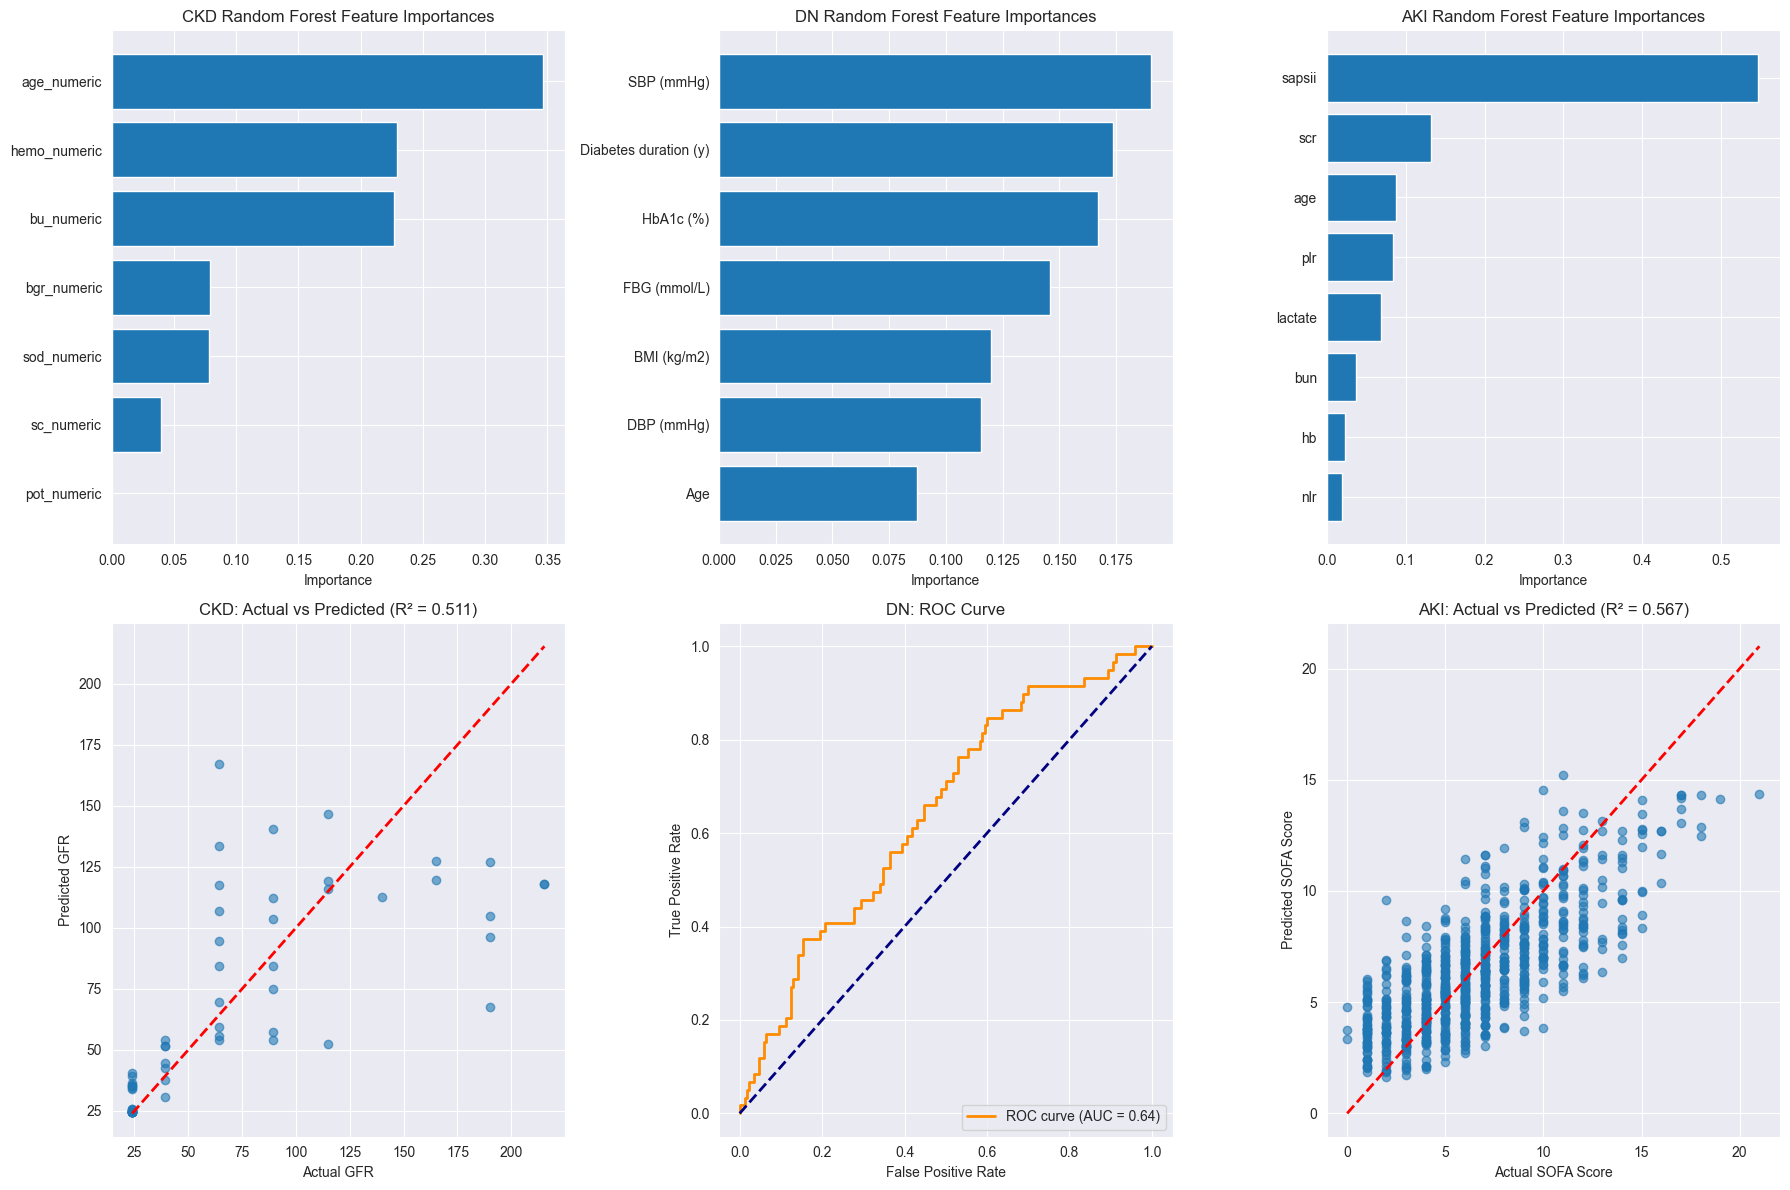

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

ax1 = axes[0, 0]
feature_importance_ckd = pd.DataFrame({
    'feature': ckd_features,
    'importance': best_rf_ckd_random.feature_importances_
}).sort_values('importance', ascending=False)

ax1.barh(feature_importance_ckd['feature'], feature_importance_ckd['importance'])
ax1.set_xlabel('Importance')
ax1.set_title('CKD Random Forest Feature Importances')
ax1.invert_yaxis()

ax2 = axes[0, 1]
feature_importance_dn = pd.DataFrame({
    'feature': dn_features,
    'importance': best_rf_dn_random.feature_importances_
}).sort_values('importance', ascending=False)

ax2.barh(feature_importance_dn['feature'], feature_importance_dn['importance'])
ax2.set_xlabel('Importance')
ax2.set_title('DN Random Forest Feature Importances')
ax2.invert_yaxis()

ax3 = axes[0, 2]
feature_importance_aki = pd.DataFrame({
    'feature': aki_features,
    'importance': best_rf_aki_random.feature_importances_
}).sort_values('importance', ascending=False)

ax3.barh(feature_importance_aki['feature'], feature_importance_aki['importance'])
ax3.set_xlabel('Importance')
ax3.set_title('AKI Random Forest Feature Importances')
ax3.invert_yaxis()

ax4 = axes[1, 0]
ax4.scatter(y_test_ckd_reg, y_pred_best_ckd_random, alpha=0.6)
ax4.plot([y_test_ckd_reg.min(), y_test_ckd_reg.max()], 
         [y_test_ckd_reg.min(), y_test_ckd_reg.max()], 'r--', lw=2)
ax4.set_xlabel('Actual GFR')
ax4.set_ylabel('Predicted GFR')
ax4.set_title(f'CKD: Actual vs Predicted (R² = {r2_best_ckd_random:.3f})')

ax5 = axes[1, 1]
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test_dn, best_rf_dn_random.predict_proba(X_test_dn)[:, 1])
roc_auc = auc(fpr, tpr)
ax5.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax5.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('DN: ROC Curve')
ax5.legend(loc="lower right")

ax6 = axes[1, 2]
ax6.scatter(y_test_aki_reg, y_pred_best_aki_random, alpha=0.6)
ax6.plot([y_test_aki_reg.min(), y_test_aki_reg.max()], 
         [y_test_aki_reg.min(), y_test_aki_reg.max()], 'r--', lw=2)
ax6.set_xlabel('Actual SOFA Score')
ax6.set_ylabel('Predicted SOFA Score')
ax6.set_title(f'AKI: Actual vs Predicted (R² = {r2_best_aki_random:.3f})')

plt.tight_layout()
plt.show()

The first thing that stood out to me is that the CKD graph had the data points a lot more spread out from the red line compared to AKI. However, both of them have similar r^2 with 0.511 and 0.567 respectively. I realized that this was because the y-axis on CKD goes up to 200 compared to the y-axis on AKI only going up to 20. Since the data points are the absolute distance which is why they look better on the AKI graph.

The ROC AUC = 0.64 is fine, but could be more closer to 1. Really we would like a high TPR and FPR meaning it would be on the top left.

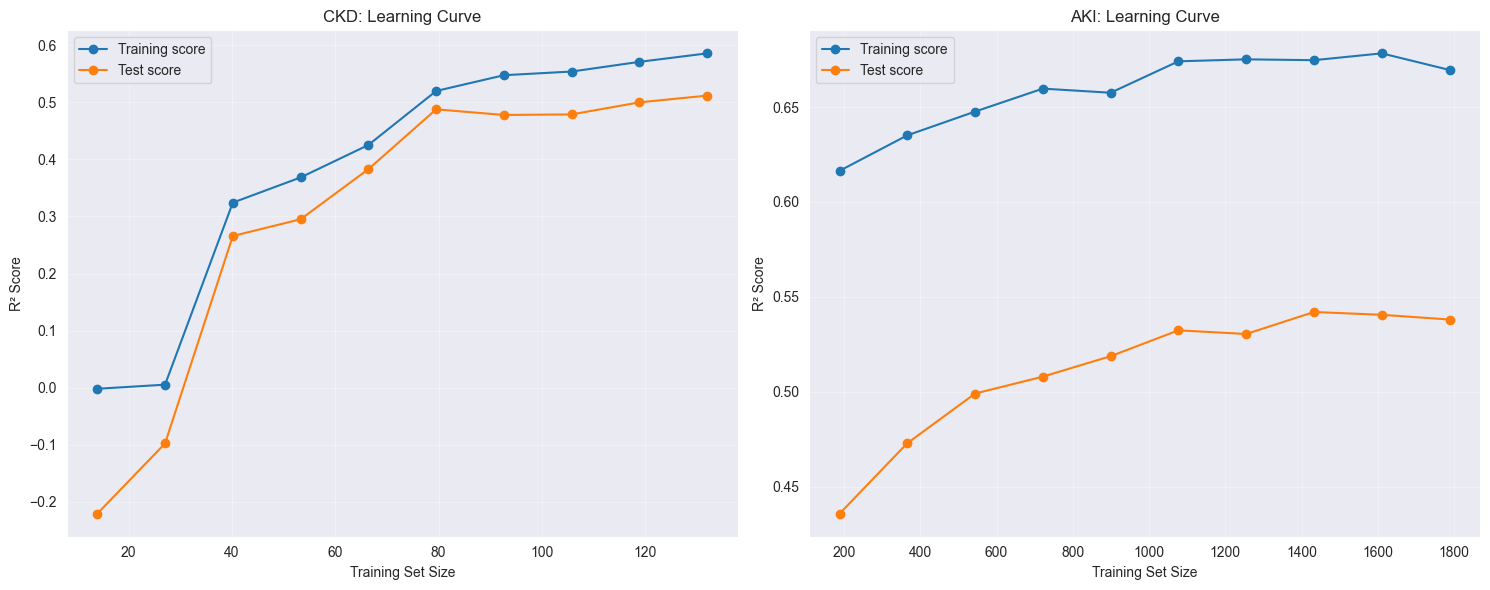

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

train_sizes_ckd = np.linspace(0.1, 0.95, 10)
train_scores_ckd = []
test_scores_ckd = []

for train_size in train_sizes_ckd:
    X_subset, _, y_subset, _ = train_test_split(
        X_train_ckd_reg, y_train_ckd_reg, 
        train_size=train_size, random_state=42
    )
    rf_temp = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42
    )
    rf_temp.fit(X_subset, y_subset)
    
    train_pred = rf_temp.predict(X_subset)
    test_pred = rf_temp.predict(X_test_ckd_reg)
    
    train_scores_ckd.append(r2_score(y_subset, train_pred))
    test_scores_ckd.append(r2_score(y_test_ckd_reg, test_pred))

ax1.plot(train_sizes_ckd * len(X_train_ckd_reg), train_scores_ckd, 'o-', label='Training score')
ax1.plot(train_sizes_ckd * len(X_train_ckd_reg), test_scores_ckd, 'o-', label='Test score')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('R² Score')
ax1.set_title('CKD: Learning Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

train_sizes_aki = np.linspace(0.1, 0.95, 10)
train_scores_aki = []
test_scores_aki = []

for train_size in train_sizes_aki:
    X_subset, _, y_subset, _ = train_test_split(
        X_train_aki_reg, y_train_aki_reg,
        train_size=train_size, random_state=42
    )
    rf_temp = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42
    )
    rf_temp.fit(X_subset, y_subset)
    
    train_pred = rf_temp.predict(X_subset)
    test_pred = rf_temp.predict(X_test_aki_reg)
    
    train_scores_aki.append(r2_score(y_subset, train_pred))
    test_scores_aki.append(r2_score(y_test_aki_reg, test_pred))

ax2.plot(train_sizes_aki * len(X_train_aki_reg), train_scores_aki, 'o-', label='Training score')
ax2.plot(train_sizes_aki * len(X_train_aki_reg), test_scores_aki, 'o-', label='Test score')
ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('R² Score')
ax2.set_title('AKI: Learning Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

CKD learning curve looks better than the AKI learning curve since training score and tests score follow each other more closely. The final score ends around 0.6 and 0.5 for CKD and 0.65 and 0.55 for AKI. This small gap means that the model is actually predicting the data better as supposed to overfitting and just memorizing.

### 3.10 Model Comparison and Summary

In [39]:
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)

print("\nRegression Models Summary:")
print("-" * 80)
regression_summary = pd.DataFrame({
    'Dataset': ['CKD', 'CKD', 'CKD', 'AKI', 'AKI', 'AKI'],
    'Model': ['Baseline', 'GridSearch', 'RandomSearch', 'Baseline', 'GridSearch', 'RandomSearch'],
    'Target': ['GFR', 'GFR', 'GFR', 'SOFA', 'SOFA', 'SOFA'],
    'R²': [r2_ckd, r2_best_ckd, r2_best_ckd_random, r2_aki, r2_best_aki, r2_best_aki_random],
    'RMSE': [rmse_ckd, rmse_best_ckd, np.sqrt(mean_squared_error(y_test_ckd_reg, y_pred_best_ckd_random)),
             rmse_aki, rmse_best_aki, np.sqrt(mean_squared_error(y_test_aki_reg, y_pred_best_aki_random))]
})
print(regression_summary.to_string(index=False))

print("\n\nClassification Models Summary:")
print("-" * 80)
classification_summary = pd.DataFrame({
    'Dataset': ['CKD', 'DN', 'DN', 'DN', 'AKI'],
    'Model': ['Baseline', 'Baseline', 'GridSearch', 'RandomSearch', 'Baseline'],
    'Target': ['CKD Status', 'DN Status', 'DN Status', 'DN Status', '28-day Mortality'],
    'Accuracy': [accuracy_ckd_class, accuracy_dn, accuracy_best_dn, accuracy_best_dn_random, accuracy_aki_class],
    'F1-Score': [f1_ckd_class, f1_dn, f1_best_dn, f1_best_dn_random, f1_aki_class]
})
print(classification_summary.to_string(index=False))

print("\n\nKey Findings:")
print("-" * 60)
print("1. CKD Dataset:")
print(f"   - Best R² achieved: {r2_best_ckd_random:.4f} (RandomizedSearch)")
print(f"   - Classification accuracy: {accuracy_ckd_class:.4f}")
print(f"   - Most important feature:  {feature_importance_ckd.iloc[0]['feature']}")

print("\n2. Diabetic Nephropathy Dataset:")
print(f"   - Best accuracy: {accuracy_best_dn_random:.4f} (RandomizedSearch)")
print(f"   - Best F1-Score: {f1_best_dn_random:.4f}")
print(f"   - Most important feature: {feature_importance_dn.iloc[0]['feature']}")

print("\n3. AKI Dataset:")
print(f"   - Best R² achieved: {r2_best_aki_random:.4f} (RandomizedSearch)")
print(f"   - Classification accuracy: {accuracy_aki_class:.4f}")
print(f"   - Most important feature: {feature_importance_aki.iloc[0]['feature']}")

COMPREHENSIVE MODEL COMPARISON SUMMARY

Regression Models Summary:
--------------------------------------------------------------------------------
Dataset        Model Target       R²      RMSE
    CKD     Baseline    GFR 0.411853 43.084263
    CKD   GridSearch    GFR 0.455348 41.460552
    CKD RandomSearch    GFR 0.511488 39.265700
    AKI     Baseline   SOFA 0.558837  2.416111
    AKI   GridSearch   SOFA 0.566836  2.394107
    AKI RandomSearch   SOFA 0.566686  2.394520


Classification Models Summary:
--------------------------------------------------------------------------------
Dataset        Model           Target  Accuracy  F1-Score
    CKD     Baseline       CKD Status  0.950000  0.958904
     DN     Baseline        DN Status  0.742358  0.233766
     DN   GridSearch        DN Status  0.698690  0.241758
     DN RandomSearch        DN Status  0.711790  0.340000
    AKI     Baseline 28-day Mortality  0.775713  0.267206


Key Findings:
---------------------------------------------

# Comprehensive Model Comparison Summary

## Regression Models Summary

| Dataset | Model | Target | R² | RMSE |
|---------|-------|--------|-----|------|
| CKD | Baseline | GFR | 0.411853 | 43.084263 |
| CKD | GridSearch | GFR | 0.455348 | 41.460552 |
| CKD | RandomSearch | GFR | 0.511488 | 39.265700 |
| AKI | Baseline | SOFA | 0.558837 | 2.416111 |
| AKI | GridSearch | SOFA | 0.566836 | 2.394107 |
| AKI | RandomSearch | SOFA | 0.566686 | 2.394520 |

## Classification Models Summary

| Dataset | Model | Target | Accuracy | F1-Score |
|---------|-------|--------|----------|----------|
| CKD | Baseline | CKD Status | 0.950000 | 0.958904 |
| DN | Baseline | DN Status | 0.742358 | 0.233766 |
| DN | GridSearch | DN Status | 0.698690 | 0.241758 |
| DN | RandomSearch | DN Status | 0.711790 | 0.340000 |
| AKI | Baseline | 28-day Mortality | 0.775713 | 0.267206 |

## Key Findings

### Model Performance Analysis
The Random Forest models performed well with the CKD dataset. RandomizedSearchCV had an r^2 of 0.5115. This shows an improvement over the linear baseline. The accuracy reached 0.95 which shows the ability to determine if a patient had CKD vs not having CKD. Age was the most important feature.

The Diabetic Nephropathy dataset was a bit more challenging. Accuracy was pretty good with 0.7118 for RandomizedSearchCV. However, the F1-Score was only at 0.34. This shows the class imbalances in the dataset. Systolic blood pressure (SBP) was the most important feature.

For the AKI dataset, RandomizedSearchCV got an r^2 of 0.5667. The accuracy was 0.7757. SAPS II was the most important feature. This shows that severity markers are strong predictions of acute kidney injury.

### Model Performance Insights
The Random Forest models showed strong performance with all datasets. They were good at capturing non-linear relationships. The hyperparameter tuning improved the performance for each of the datasets. RandomizedSearchCV often discovered better parameter combinations compared to GridSearchCV in fewer iterations. Overall this shows that Random Forest is good for medication predictions where there are complex interactions with the different variables.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.